### 导入运行程序，建立路网、交叉口信号灯，设置到达离去

In [1]:
from ctmnet2.simulation import Simulator
from ctmnet2.networkcreation import create_from_xml

def neta(Area="",Ver=""):
    U=[1,2,3,4]
    D=[5,6,7,8]
    sim = create_from_xml("NET-"+Area+Ver+".xml")
    sim.set_arrival(str(U[0]),1412*4)
    sim.set_departure(str(D[0]),1412*4)
    sim.set_arrival(str(U[1]),1412*3)
    sim.set_departure(str(D[1]),1412*3)
    sim.set_arrival(str(U[2]),1412*3)
    sim.set_departure(str(D[2]),1412*3)
    sim.set_arrival(str(U[3]),1412*3)
    sim.set_departure(str(D[3]),1412*3)
    return sim

### 路灯检测数据输入

In [2]:
import xml.etree.ElementTree as ET
import re

def deta(sim,Area=""):
    sec_tree=ET.parse("sec_det-"+Area+".xml")
    det_tree=ET.parse("detectors-"+Area+".xml")
    secs=sec_tree.getroot()
    dets=det_tree.getroot()
    for sec in secs.iter('section'):
        sec_id=sec.attrib['id']
        det_id=re.findall(r"\d+",sec.find('detectors').text)
        #print(sec_id,det_id)
        n=0
        for i in det_id:
            for det in dets.iter('detector'):
                if det.attrib['id']==i:
                    vol=float(det.find('volume').text)
                    sim.sections[sec_id].cells[int(n)].volume=vol
                    n=n+1
    return sim

### 开始仿真

In [3]:
def simula(sim,T=600,R='volume',S='cell'):
    result=[]
    r=[]
    s=0
    for i in range(T):
        r=[]
        s=0
        sim.run_single_step()
        if R=='volume':
            V=sim.get_volume(S)
        elif R=='density':
            V=sim.get_density(S)
        elif R=='velocity':
            V=sim.get_velocity(S)
        elif R=='occupancy':
            V=sim.get_occupancy(S)
        if S=='cell':
            for j in range(1,9):
                t=[]
                for k in range(len(V[str(j)])):
                    t.append(V[str(j)][k])
                r=r+[round(i,1) for i in t]
            result.append(r)
        elif S=='section':
            for j in range(1,9):
                s=s+V[str(j)]
            result.append(s/8)
    return result

### 矩阵转置

In [4]:
def maTrix(matrix):
    T=[]
    for i in range(len(matrix[0])):
        t=[]
        for j in range(len(matrix)):
            t.append(matrix[j][i])
        T.append(t)
    return T

### 提取路网中各路段元胞坐标

In [5]:
import xml.etree.ElementTree as ET
import re

def coora(Area=""):
    tree = ET.parse("NET-"+Area+".xml")
    root = tree.getroot()
    para = 'coordinates'
    coordinates=[]
    for sec in root.iter('section'):
        sec_id = sec.attrib['id']
        coors = re.findall(r"(\d+\.?\d*, \d+\.?\d*)",sec.find(para).text)
        COORS = []
        COOR = []
        for coor in coors:
            COOR = coor.split(',')
            COOR[0] = float(COOR[0])
            COOR[1] = float(COOR[1])
            COORS.append(COOR)
        coordinates.extend(COORS)
    return coordinates

### 仿真后生成HTML文件

In [6]:
import webbrowser
from IPython.display import IFrame

def visula(Matrix,Coor,Area="",R=""):
    with open("HMWT-"+R+"-"+Area+".html",'r',encoding='utf-8') as file:
        with open("HMWT-"+R+"-"+Area+"+.html",'w',encoding='utf-8') as out:
            load=file.read()
            p1,pr=load.split("元胞坐标")
            out.write(p1+'\n')
            for coor in Coor:
                out.write('{"lat":'+str(coor[0])+',"lng":'+str(coor[1])+'},\n')
            p2,pr=pr.split("元胞流量数据")
            out.write(p2+'\n')
            for t in Matrix:
                out.write(str(t)+',\n')
            out.write(pr)

    return IFrame(src='HMWT-'+R+"-"+Area+'+.html', width=600, height=600)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
#定义待优化函数：只能处理行向量形式的单个输入，若有矩阵形式的多个输入应当进行迭代
def CostFunction(x):
    '''x1=int(round(x[0]))
    x2=int(round(x[1]))
    x3=int(round(x[2]))
    x4=int(round(x[3]))'''
    x1=int(x[0])
    x2=int(x[1])
    x3=int(x[2])
    x4=int(x[3])
    phastr=str(x1)+' '+str(x2)+' '+str(x3)+' '+str(x4)
    global phaset
    global nss
    if phastr in phaset.keys():
        nss+=1
        return phaset[phastr]
    with open("NET-BJH.xml",'r',encoding='utf-8') as file:
        with open("NET-BJH0.xml",'w',encoding='utf-8') as out:
            load=file.read()
            p1,pr=load.split("[47, 35, 38, 28]")
            out.write(p1)
            out.write('['+str(x1)+', '+str(x2)+', '+str(x3)+', '+str(x4)+']')
            out.write(pr)
    sim=neta(Area,'0')
    sim=deta(sim,Area)
    R='density'
    result=simula(sim,900,R,'section')
    global ns
    ns+=1
    #目标函数
    result=sum(result)/len(result)
    phaset[phastr]=result
    return result

In [8]:
def ABC():
    #代价函数中参数数目和范围
    nVar=4
    VarMin=25
    VarMax=50

    #蜂群算法基本参数
    iter_max=100 #最大迭代次数
    nPop=20 #单次保存的蜜源最大数量
    nOnLooker=20 #跟随峰数量
    L=np.around(0.6*nVar*nPop) #蜜源抛弃上界
    a=1 #蜜源搜索范围扩大系数

    #创建各记录矩阵
    PopPosition=np.zeros([nPop,nVar]) #蜜源位置矩阵
    PopCost=np.zeros([nPop,1]) #蜜源代价矩阵
    Probability=np.zeros([nPop,1]) #蜜源选择概率矩阵
    BestSol=np.zeros([iter_max+1,nVar]) # 历史最优蜜源矩阵
    BestCost=np.inf*np.ones([iter_max+1,1]) #历史最优蜜源位置矩阵
    Mine=np.zeros([nPop,1]) #蜜源开采量矩阵

    #初始化蜜源位置
    PopPosition=(VarMax-VarMin)*np.random.rand(nPop,nVar)+VarMin
    for i in range(nPop):
        PopPosition[i]=[int(round(p)) for p in PopPosition[i]]
        PopCost[i][0]=CostFunction(PopPosition[i])
        if PopCost[i][0]<BestCost[0][0]:
            BestCost[0][0]=PopCost[i][0]
            BestSol[0]=PopPosition[i]

    for iter in range(iter_max):
        global ns
        print(ns)

        #雇佣蜂阶段

        #寻找下一个蜜源
        for i in range(nPop):
            phi=a*np.random.rand(nVar)
            NewPosition=VarMin+phi*(VarMax-VarMin)
            NewPosition=[int(round(p)) for p in NewPosition]

            #进行贪婪选择
            NewCost=CostFunction(NewPosition)
            if NewCost<PopCost[i][0]:
                PopPosition[i]=NewPosition
                PopCost[i][0]=NewCost
            else:
                Mine[i][0]=Mine[i][0]+1

        #跟随蜂阶段

        #计算选择概率矩阵
        Mean=np.mean(PopCost)
        for i in range(nPop):
            Probability[i][0]=np.exp(-PopCost[i][0]/Mean)
        Probability=Probability/np.sum(Probability)
        CumProb=np.cumsum(Probability)

        for k in range(nOnLooker):

            #执行轮盘赌选择法
            m=0
            for i in range(nPop):
                m=m+CumProb[i]
                if m>=np.random.rand(1):
                    break

            #重复雇佣蜂操作
            phi=a*np.random.rand(nVar)
            NewPosition=VarMin+phi*(VarMax-VarMin)
            NewPosition=[int(round(p)) for p in NewPosition]

            #进行贪婪选择
            NewCost=CostFunction(NewPosition)
            if NewCost<PopCost[i][0]:
                PopPosition[i]=NewPosition
                PopCost[i][0]=NewCost
            else:
                Mine[i][0]=Mine[i][0]+1

        #侦查蜂阶段
        for i in range(nPop):
            if Mine[i][0]>=L:
                PopPosition[i]=(VarMax-VarMin)*np.random.rand(1,nVar)+VarMin
                PopPosition[i]=[int(round(p)) for p in PopPosition[i]]
                PopCost[i][0]=CostFunction(PopPosition[i])
                Mine[i][0]=0

        #保存历史最优解
        for i in range(nPop):
            if PopCost[i][0]<BestCost[iter+1][0]:
                BestCost[iter+1][0]=PopCost[i][0]
                BestSol[iter+1]=PopPosition[i]
        
    #输出结果
    y=np.zeros(iter_max+1)
    for i in range(iter_max+1):
        print(i,BestCost[i],BestSol[i])
        y[i]=BestCost[i][0]
    print(min(y),BestSol[np.argmin(y)])
    x=[i for i in range(iter_max+1)]
    plt.plot(x,y)
    plt.show()

In [9]:
Area="BJH"
R="density"
sim=neta(Area)
sim=deta(sim,Area)
result=simula(sim,900,R)
Result=maTrix(result)
Coor=coora(Area)
visula(Result,Coor,Area,R)

20
60
100
140
180
220
260
300
341
382
422
463
503
543
583
622
663
705
745
785
825
866
907
946
986
1028
1068
1108
1149
1189
1229
1270
1309
1350
1391
1431
1472
1513
1553
1593
1632
1673
1713
1753
1793
1834
1874
1914
1955
1998
2041
2083
2125
2170
2211
2251
2291
2331
2371
2412
2452
2493
2533
2573
2613
2653
2695
2735
2775
2815
2855
2896
2936
2975
3015
3055
3096
3138
3179
3219
3259
3300
3341
3380
3419
3459
3500
3540
3579
3620
3660
3701
3740
3780
3819
3859
3900
3940
3980
4021
0 [3.32993833] [50. 45. 47. 48.]
1 [3.25736833] [48. 25. 46. 32.]
2 [3.25736833] [48. 25. 46. 32.]
3 [3.25736833] [48. 25. 46. 32.]
4 [3.25736833] [48. 25. 46. 32.]
5 [3.25736833] [48. 25. 46. 32.]
6 [3.25736833] [48. 25. 46. 32.]
7 [3.25736833] [48. 25. 46. 32.]
8 [3.25736833] [48. 25. 46. 32.]
9 [3.25736833] [48. 25. 46. 32.]
10 [3.25302028] [46. 28. 33. 26.]
11 [3.25302028] [46. 28. 33. 26.]
12 [3.25302028] [46. 28. 33. 26.]
13 [3.25302028] [46. 28. 33. 26.]
14 [3.25302028] [46. 28. 33. 26.]
15 [3.25302028] [46. 28. 33

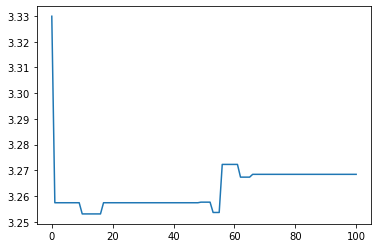

4065 18
Wall time: 28min 7s


In [10]:
%%time
phaset={}
ns=0
nss=0
ABC()
print(ns,nss)

In [15]:
from collections import Counter
a=phaset.keys()
b=Counter(a)
len(b)

4065